In [1]:
import sys
sys.path.append("scripts/")
from GridMap import *
import math
from matplotlib.animation import PillowWriter    #アニメーション保存用

In [2]:
class Astar():
    def __init__(self, grid_map_world):
        self.world = grid_map_world
        self.grid_map = grid_map_world.grid_map
        self.cost_map = np.full(self.grid_map.shape, 1)    #その地点が持つコスト
        self.id_map = np.full(self.grid_map.shape, 0)
        self.parent_id_map = np.full(self.grid_map.shape, 0)
        self.h_map = np.full(self.grid_map.shape, 0)
        self.flag_path_draw = 0  #経路描画のフラグ
        
        self.open_list = []
        self.closed_list = []
        
        index = 0
        for index_x, grids in enumerate(self.grid_map):
            for index_y, grid in enumerate(grids):
                self.id_map[index_x][index_y] = index;
                self.h_map[index_x][index_y] = 10*math.sqrt((self.world.goal_index[0]-index_x)**2+(self.world.goal_index[1]-index_y)**2)
                #self.h_map[index_x][index_y] = abs(self.world.goal_index[0]-index_x) + abs(self.world.goal_index[1]-index_y)
                if(grid == '2'):
                    self.open_list.append([index, self.h_map[index_x][index_y], 0])
                index += 1        
    
    def draw(self, ax, elems):
        if not(self.id_map[self.world.goal_index[0]][self.world.goal_index[1]] in [val[0] for val in self.closed_list]): #ゴールにたどり着いていなければコストを計算
            val = np.argmin(self.open_list, axis=0) #評価マップの中から最も小さいもの抽出
            grid_id = self.open_list[val[1]][0]
            cost_f = self.open_list[val[1]][1]
            cost_g = self.open_list[val[1]][2]
            
            idx = np.where(self.id_map==grid_id)
            index = [idx[0][0], idx[1][0]]
            
            self.open_list.remove([grid_id, cost_f, cost_g])  #オープンリストから削除
            self.closed_list.append([grid_id, cost_f, cost_g])  #クローズドリストに追加
            
            if(self.world.grid_map[index[0]][index[1]]!='2' and self.world.grid_map[index[0]][index[1]]!='3'):
                c = "blue"
                fill = False
                alpha = 1.0
                
                #評価をカラーマップに出力する場合はこの部分のコメントをアウトを外す
                #マップに合わせて調整が必要
                
                c_num = int(cost_f - 270) #Black→Blue
                c_num = int(c_num  * 1.2)
                #print(cost_f, c_num)
                if(c_num > 0xff): #Blue → Cyan
                    c_num = (c_num-0xff)*16*16 + 0xff
                    if(c_num > 0xffff): #Cyan → Green
                        c_num = 0xffff - int((c_num-0x100ff)*4/256)
                        if(c_num < 0xff00): #Green →Yellow
                            c_num = (0xff00-c_num)*65536+0xff00
                            if(c_num > 0xffff00): #Yellow → Red
                                c_num = 0xffff00 - int((c_num-0xffff00)*0.5/65536)*256
                fill = True
                alpha = 0.5
                c = '#' + format(int(c_num), 'x').zfill(6)
                
                #print(c, cost_f)
                r = patches.Rectangle(
                    xy=((index[0])*self.world.grid_step[0], (index[1])*self.world.grid_step[1]),
                    height=self.world.grid_step[0],
                    width=self.world.grid_step[1],
                    color=c,
                    fill=fill,
                    alpha=alpha
                )
                ax.add_patch(r)
            
            for i in range(-1, 2):
                if(index[0]+i<0 or index[0]+i>self.cost_map.shape[0]-1): #地図の範囲外か（x軸方向）
                    continue;
                for j in range(-1, 2):
                    if(index[1]+j<0 or index[1]+j>self.cost_map.shape[1]-1): #地図の範囲外か（y軸方向）
                        continue;
                    if(i==0 and j==0): #自分か
                        continue;
                    elif(self.grid_map[index[0]+i][index[1]+j] == '0'): #障害物か
                        continue;
                    else:
                        #評価を計算
                        evaluation_f = \
                            cost_g \
                            + self.cost_map[index[0]+i][index[1]+j] \
                            + 10*math.sqrt(i**2+j**2) \
                            + self.h_map[index[0]+i][index[1]+j]
                        
                        if(self.id_map[index[0]+i][index[1]+j] in [val[0] for val in self.open_list]): #オープンリストに含まれているか
                            its_index, its_cost_f, its_cost_g = self.open_list[[val[0] for val in self.open_list].index(self.id_map[index[0]+i][index[1]+j])]
                            if(its_cost_f > evaluation_f): #評価が更新されなければ繰り返しを戻す
                                self.open_list.remove([its_index, its_cost_f, its_cost_g])
                            else:
                                continue;
                        elif(self.id_map[index[0]+i][index[1]+j] in [val[0] for val in self.closed_list]): #クローズドリストに含まれているか 
                            its_index, its_cost_f, its_cost_g = self.closed_list[[val[0] for val in self.closed_list].index(self.id_map[index[0]+i][index[1]+j])]
                            if(its_cost_f > evaluation_f):
                                self.closed_list.remove([its_index, its_cost_f, its_cost_g])  
                            else:
                                continue;
                        self.parent_id_map[index[0]+i][index[1]+j] = self.id_map[index[0]][index[1]]
                        self.open_list.append([
                            self.id_map[index[0]+i][index[1]+j], \
                            evaluation_f, \
                            evaluation_f - self.h_map[index[0]+i][index[1]+j]
                        ])
        else:
            if(self.flag_path_draw == 0):
                parent_id = self.parent_id_map[self.world.goal_index[0]][self.world.goal_index[1]]
                while(parent_id != self.id_map[self.world.start_index[0]][self.world.start_index[1]]):
                    parent = np.where(self.id_map==parent_id)
                    parent_id = self.parent_id_map[int(parent[0])][int(parent[1])]
                    r = patches.Rectangle(
                        xy=((parent[0])*self.world.grid_step[0], (parent[1])*self.world.grid_step[1]),
                        height=self.world.grid_step[0],
                        width=self.world.grid_step[1],
                        color="red",
                        fill=True,
                        alpha=0.5
                    )
                    ax.add_patch(r)
                self.flag_path_draw = 1
                #print(self.flag_path_draw)

<IPython.core.display.Javascript object>


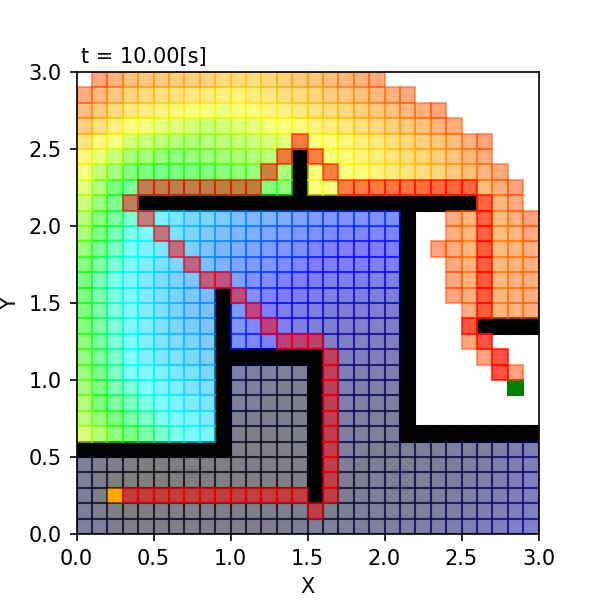

In [3]:
if __name__ == "__main__":
    time_span = 10
    time_interval = 0.01
    
    grid_step = np.array([0.1, 0.1])
    grid_num = np.array([30, 30])
    
    map_data = "csvmap/map2.csv"
    
    world = GridMapWorld(grid_step, grid_num, time_span, time_interval, map_data, debug=False)
    world.append(Astar(world))
    
    world.draw()
    #world.ani.save('astar_map2.gif', writer='pillow', fps=100)    #アニメーション保存